# Import the required libraries

In [1]:
# Regular expression to remove the unwanted charaters
import re

# Pandas to store the dataset and make the necessary operations for EDA
import pandas as pd

# Matplotlib to visualize our data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NLTK tools to help clean the string for the model to train
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string

# Tfdf vectorizer to convert the words into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# To split the data for train and test
from sklearn.model_selection import train_test_split

# Metrics to measure the performance and accuracy for the model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# Calculate the model running time
import time

# Use counter to calculated the most common words
from collections import Counter

# Exploratory Data Analysis

### Load the data

In [2]:
spam_df = pd.read_csv('spam.csv', encoding='latin-1')
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Drop the unwanted columns

In [3]:
spam_df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
df = spam_df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Rename the columns

In [5]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Check for duplicate values

In [6]:
df.duplicated().sum()

403

### Remove the duplicates

In [7]:
df = df.drop_duplicates(keep='first')
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Convert the target column into numerical values

In [8]:
from sklearn.preprocessing import LabelEncoder
df['target'] = LabelEncoder().fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Count the total number of spam and not spam text

In [9]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

### Lets visualize the spam count in pie chart

([<matplotlib.patches.Wedge at 0x2c3f1669430>,
 [Text(-1.0144997251399075, 0.4251944351600247, 'not spam'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001344, '87.37'),
  Text(0.5533635081542612, -0.23192418555038377, '12.63')])

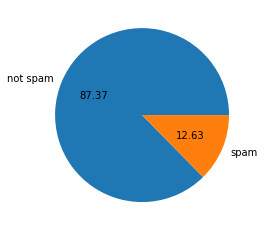

In [10]:
plt.pie(df['target'].value_counts(), labels=['not spam', 'spam'], autopct='%0.2f')

### Lets create a new column to keep the number of characters in each text

In [11]:
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


### Lets create a new column to keep the number of words in each text

In [12]:
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


### Lets create a new column to keep the number of sentences in each text

In [13]:
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [14]:
class SpamClassifier():
    def __init__(self, X, y, max_features):
        self.max_features = max_features
        
        X_vec = self.transform_and_vectorize(X);
        self.plot_most_common_words();
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_vec, y, 
                                                                                test_size=0.2, 
                                                                                random_state=42)
        
    # Clean the feature column
    def transform_text(self, text, method, method_name):
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        text = text.split()
        words = []
        if method_name == 'stemmer':
            words = [method.stem(word) for word in text if word not in stopwords.words('english') and word not in string.punctuation]
        else:
            words = [method.lemmatize(word) for word in text if word not in stopwords.words('english') and word not in string.punctuation]
        return ' '.join(words)
    
    # Convert the feature column into vectors
    def data_into_vector(self, X):
        tfidf = TfidfVectorizer(max_features=self.max_features)
        return tfidf.fit_transform(X)
    
    # Clean the feature using portal stemming
    def using_stemming(self, X):
        stemmer = PorterStemmer()
        return X.apply(lambda x: self.transform_text(x, stemmer, 'stemmer'))
    
    # Clean the feature using snowball stemming
    def using_stemming(self, X):
        stemmer = SnowballStemmer('english')
        return X.apply(lambda x: self.transform_text(x, stemmer, 'stemmer'))
    
    # Clean the feature using lemmatization
    def using_lemmatization(self, X):
        lemma = WordNetLemmatizer()
        return X.apply(lambda x: self.transform_text(x, lemma, 'lemma'))
    
    # Transform and vectorize the text
    def transform_and_vectorize(self, X):
        df['transform_text'] = self.using_stemming(X)
        return self.data_into_vector(df['transform_text'])
    
    # Count the total number of words in the list of text
    def calculate_the_total_words(self, target):
        corpus = []
        for text in df[df['target'] == target]['transform_text'].tolist():
            for word in text.split():
                corpus.append(word)
        return corpus
    
    # Plot barplot from corpus
    def plot_barplot(self, corpus, x_label):
        plt.figure(figsize=(18, 6))
        sns.barplot(pd.DataFrame(Counter(corpus).most_common(30))[0], pd.DataFrame(Counter(corpus).most_common(30))[1])
        plt.xticks(rotation='vertical')
        plt.xlabel(x_label)
        plt.ylabel('Number of words')
        plt.show()
    
    # Plot the graph for most common words in the data for spam and not spam text
    def plot_most_common_words(self):
        corpus_spam = self.calculate_the_total_words(0)
        corpus_not_spam = self.calculate_the_total_words(1)
        
        self.plot_barplot(corpus_spam, 'Most common non spam words')
        self.plot_barplot(corpus_not_spam, 'Most common spam words')
    
    # Training the model
    def model_train(self, X_train, y_train, classifier):
        print(classifier)
        return classifier.fit(X_train, y_train)
    
    # Prediction from model
    def model_prediction(self, model, X_test):
        return model.predict(X_test)
    
    # Count number of prediction are true or false using confusion matrix
    def model_confusion_matrix(self, y_test, y_pred):
        return confusion_matrix(y_test, y_pred)
    
    # Model accuracy score
    def model_accuracy(self, y_test, y_pred):
        return accuracy_score(y_test, y_pred)
    
    # Model precision score
    def model_precision(self, y_test, y_pred):
        return precision_score(y_test, y_pred)
        
    # Train the model and check the performance
    def train_check_performance(self, classifier):
        model = self.model_train(self.X_train, self.y_train, classifier)
        y_pred = self.model_prediction(model, self.X_test)

        confusion_mat = self.model_confusion_matrix(self.y_test, y_pred)
        accuracy = self.model_accuracy(self.y_test, y_pred)
        precision = self.model_precision(self.y_test, y_pred)

        return (model, y_pred, confusion_mat, accuracy, precision)
    
    # Call this to train model
    def run_classifier(self, classifier):
        return self.train_check_performance(classifier)

In [15]:
performance_matrix = []
def run_classifier_check_performance(spam_classifier, classifier):
    model, y_pred, confusion_mat, accuracy, precision = spam_classifier.run_classifier(classifier)
    performance_matrix.append({'Classifier': classifier, 'Accuracy': accuracy, 'Precision': precision})
    print("==============================================================")
    print("Confusion Matrix:\n", confusion_mat)
    print("==============================================================")
    print("Accuracy:", accuracy)
    print("==============================================================")
    print("Precision:", precision)
    print("==============================================================")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


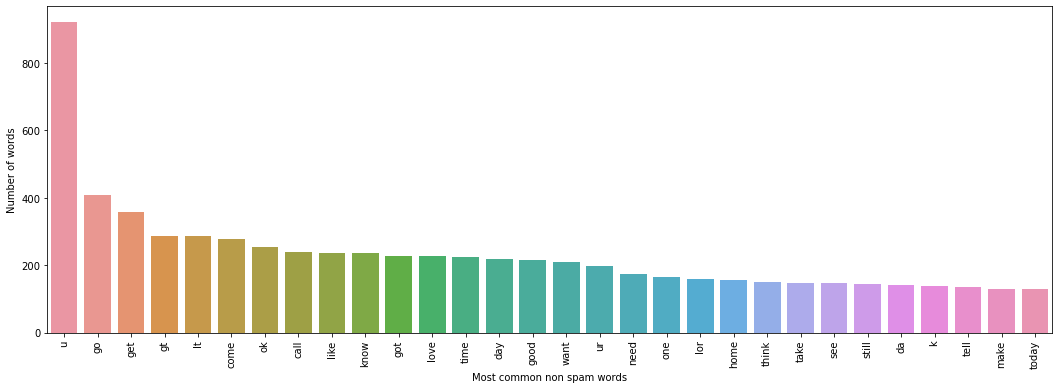

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


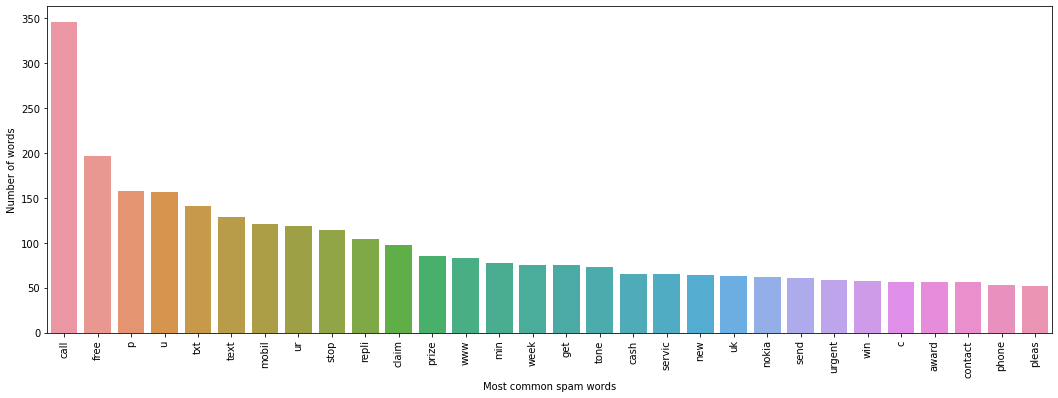

In [16]:
spam_classifier = SpamClassifier(df['text'], df['target'], 5000)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier

In [18]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
bnb = BernoulliNB()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
# xgb = XGBClassifier(n_estimators=50,random_state=2)

In [19]:
classifiers = [svc, knc, bnb, mnb, dtc, lrc, rfc, abc, bc, etc, gbdt] # GaussianNB() will not work on the lot of sparse data (contains a lot of zeros) it required the dense data to work properly
for classifier in classifiers:
    run_classifier_check_performance(spam_classifier, classifier)
    print()
    print()
    print()

SVC(gamma=1.0, kernel='sigmoid')
Confusion Matrix:
 [[882   7]
 [ 16 129]]
Accuracy: 0.9777562862669246
Precision: 0.9485294117647058



KNeighborsClassifier()
Confusion Matrix:
 [[889   0]
 [ 95  50]]
Accuracy: 0.9081237911025145
Precision: 1.0



BernoulliNB()
Confusion Matrix:
 [[884   5]
 [ 18 127]]
Accuracy: 0.9777562862669246
Precision: 0.9621212121212122



MultinomialNB()
Confusion Matrix:
 [[888   1]
 [ 30 115]]
Accuracy: 0.9700193423597679
Precision: 0.9913793103448276



DecisionTreeClassifier(max_depth=5)
Confusion Matrix:
 [[872  17]
 [ 37 108]]
Accuracy: 0.9477756286266924
Precision: 0.864



LogisticRegression(penalty='l1', solver='liblinear')
Confusion Matrix:
 [[876  13]
 [ 41 104]]
Accuracy: 0.9477756286266924
Precision: 0.8888888888888888



RandomForestClassifier(n_estimators=50, random_state=2)
Confusion Matrix:
 [[888   1]
 [ 23 122]]
Accuracy: 0.97678916827853
Precision: 0.991869918699187



AdaBoostClassifier(random_state=2)
Confusion Matrix:
 [[871  18]
 [ 17 1

In [20]:
df.head()

,target,text,num_characters,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri wkli comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [21]:
performance_df = pd.DataFrame(performance_matrix)
performance_df

,Classifier,Accuracy,Precision
0,"SVC(gamma=1.0, kernel='sigmoid')",0.977756,0.948529
1,KNeighborsClassifier(),0.908124,1.000000
2,BernoulliNB(),0.977756,0.962121
3,MultinomialNB(),0.970019,0.991379
4,DecisionTreeClassifier(max_depth=5),0.947776,0.864000
5,"LogisticRegression(penalty='l1', solver='libli...",0.947776,0.888889
6,"(DecisionTreeClassifier(max_features='auto', r...",0.976789,0.991870
7,"(DecisionTreeClassifier(max_depth=1, random_st...",0.966151,0.876712
8,(DecisionTreeClassifier(random_state=114693939...,0.974855,0.921986
9,"(ExtraTreeClassifier(random_state=1872583848),...",0.979691,0.992063
